## Import libraries

In [ ]:
'1:2,3:4'.split(':')

['1', '2,3', '4']

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import random
import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
traincsv = pd.read_csv('train.csv')
print(traincsv[traincsv.isna().any(1)])
print(traincsv.info())

Empty DataFrame
Columns: [source_node, destination_node]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB
None


In [ ]:
traincsv.to_csv('trainer.csv',header=False,index=False)
print("saved the graph into file")
g=nx.read_edgelist('trainer.csv',delimiter=',',create_using=nx.DiGraph())
print(nx.info(g))

saved the graph into file


Name: 
Type: DiGraph
Number of nodes: 122
Number of edges: 100
Average in degree:   0.8197
Average out degree:   0.8197


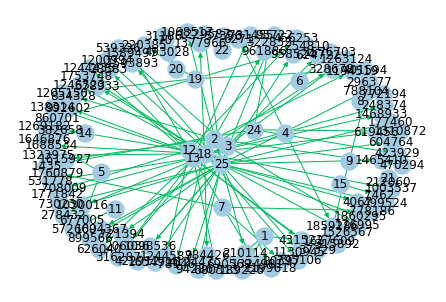

In [ ]:
## sample graph
pd.read_csv('train.csv', nrows=100).to_csv('trainer_sample.csv',header=False,index=False)
subgraph=nx.read_edgelist('trainer_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

## EDA

In [ ]:
print("The number of people",len(g.nodes()))

The number of people 1862220


#### Number of followers for each person

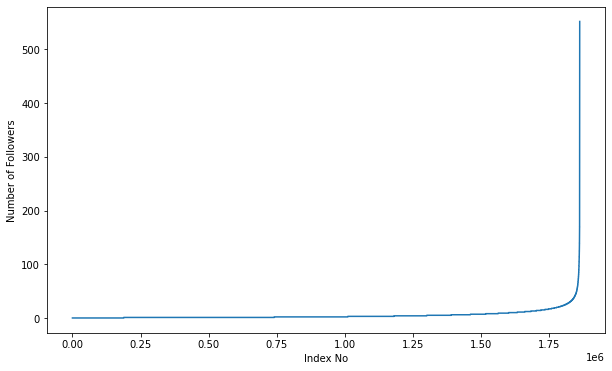

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('Number of Followers')
plt.show()



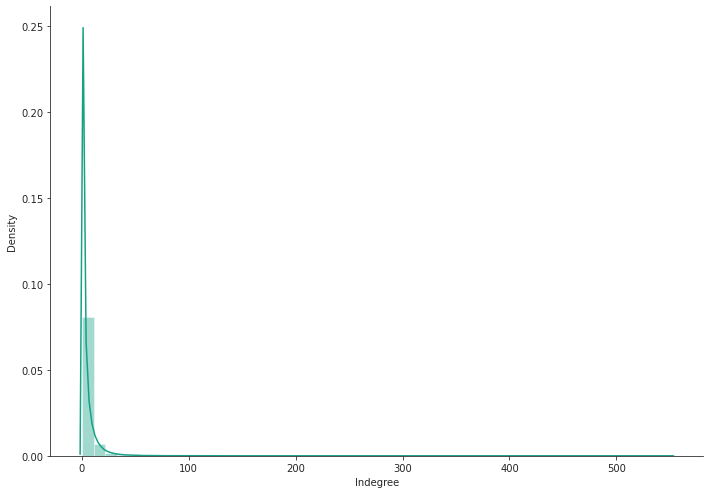

In [ ]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('Indegree')
sns.despine()
#plt.show()


#### number of following people

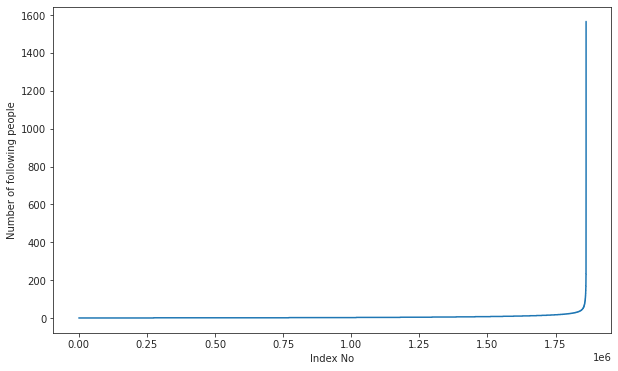

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('Number of following people')
plt.show()

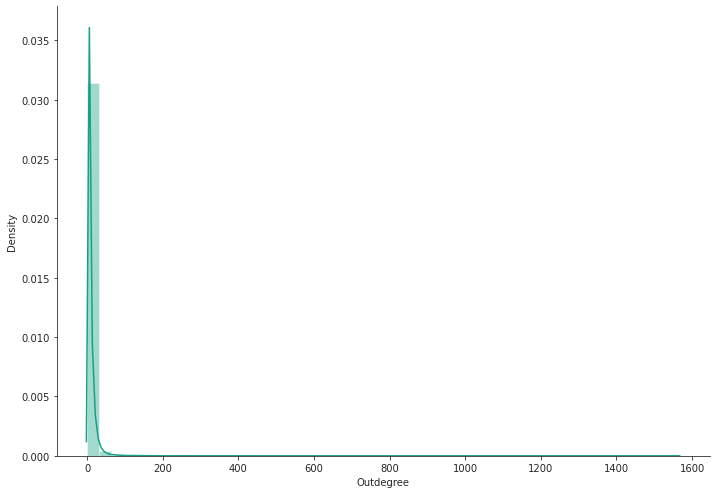

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('Outdegree')
sns.despine()

In [ ]:
print('Number of people that are not following anyone:' ,sum(np.array(outdegree_dist)==0),'; percentage:',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

print('Number of people without followers:' ,sum(np.array(indegree_dist)==0),'; percentage:',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('Number of people that are not not following anyone and without any followers:',count)

Number of people that are not following anyone: 274512 ; percentage: 14.741115442858524
Number of people without followers: 188043 ; percentage: 10.097786512871734
Number of people that are not not following anyone and without any followers: 0


## Feature Engineering

In [ ]:
## generating bad edges from given graph
edges = dict()
for edge in traincsv:
    edges[(edge[0], edge[1])] = 1
missing_edges = set([])

while (len(missing_edges)<9437519):
    a=random.randint(1, 1862220)
    b=random.randint(1, 1862220)
    tmp = edges.get((a,b),-1)
    if tmp == -1 and a!=b:
        try:
            if nx.shortest_path_length(g,source=a,target=b) > 2: 

                missing_edges.add((a,b))
            else:
                continue  
        except:  
                missing_edges.add((a,b))              
    else:
        continue
pickle.dump(missing_edges,open('missing_edges_final.p','wb'))

In [ ]:
print("missing_edges:",len(missing_edges))

missing_edges: 9437519


In [ ]:
from sklearn.model_selection import train_test_split
df_pos = pd.read_csv('train.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

In [ ]:
'''
X_train_pos.to_csv('train_pos.csv',header=False, index=False)
X_test_pos.to_csv('test_pos.csv',header=False, index=False)
X_train_neg.to_csv('train_neg.csv',header=False, index=False)
X_test_neg.to_csv('test_neg.csv',header=False, index=False)
'''

# train set and test set
X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
X_train.to_csv('train_X.csv',header=False,index=False)
X_test.to_csv('test_X.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

X_train['value'] = y_train
X_train.to_csv('full_train.csv',header=False,index=False)
X_test['value'] = y_test
X_test.to_csv('full_test.csv',header=False,index=False)

In [ ]:
with open("full_train.csv", "r") as f:
  reader = csv.reader(f)
  train = list(reader)

In [ ]:
## Create an undirected citation graph
G1 = nx.Graph()
# Add linked nodes and edges from the training set
linked_nodes = [(i[0], i[1]) for i in train if i[2] in ['1.0']]
G1.add_edges_from(linked_nodes)
# Add nodes that have no link between
no_linked_nodes = [i[0] for i in train if i[2] in ['0.0']]
no_linked_nodes.extend([i[1] for i in train if i[2] in ['0.0']])
G1.add_nodes_from(no_linked_nodes)

## Create a directed citation graph
G2 = nx.DiGraph()
# Add linked nodes and edges from the training set
G2.add_edges_from(linked_nodes)
# Add nodes that have no link between
G2.add_nodes_from(no_linked_nodes)

In [ ]:
#pickle.dump(G1, open('G1.p','wb'))
G1 = pickle.load(open('G1.p','rb'))

In [ ]:
pr = nx.pagerank(G1, alpha=0.85)

In [ ]:
nb_common_neighbors = []
adamic_adar_index = []
preferential_attachment = []
jaccard_coefficient = []
in_link_difference = []
shortest_path = []
nb_out_neighbors = []
nb_in_neighbors = []
popularity = []
nb_common_predecessors = []
nb_common_successors = []

for s1, s2, target in train:
  '''Undirected Citation Graph related features'''
  # Number of common neighbors
  nb_common_neighbors.append(len(sorted(nx.common_neighbors(G1, s1, s2))))
  # Adamic/adar index
  pred = nx.adamic_adar_index(G1, [(s1, s2)])
  for u, v, p in pred:
      adamic_adar_index.append(p)
  # Preferential attachment
  pred = nx.preferential_attachment(G1, [(s1, s2)])
  for u, v, p in pred:
      preferential_attachment.append(p)
  # Jaccard coefficient
  pred = nx.jaccard_coefficient(G1, [(s1, s2)])
  for u, v, p in pred:
      jaccard_coefficient.append(p)
        
  '''Directed Citation Graph related features'''
  # In-link difference 
  in_link_difference.append(len(G2.in_edges(s2)) - len(G2.in_edges(s1)))
  # Shortest path
  if nx.has_path(G2, s1, s2):
      shortest_path.append(nx.shortest_path_length(G2, s1, s2))
  else:
      shortest_path.append(-1)
  # Number of out-neighbors of source
  nb_out_neighbors.append(G2.in_degree(s1))
  # Number of in-neighbors of target
  nb_in_neighbors.append(G2.in_degree(s2))
  predecessors2 = G2.predecessors(s1)
  predecessors1 = G2.predecessors(s2)
  # Popularity
  pop = 0
  for p in predecessors2:
      pop += G2.in_degree(p)
  popularity.append(pop)
  # Number of common predecessors
  nb_common_predecessors.append(len(set(predecessors1).intersection(set(predecessors2))))
  successors2 = G2.successors(s2)
  successors1 = G2.successors(s1)
  # Number of common successors
  nb_common_successors.append(len(set(successors1).intersection(set(successors2))))

# get pagerank
pr = nx.pagerank(G1, alpha=0.85)
mean_pr = float(sum(pr.values())) / len(pr)

# get hits
hits = nx.hits(G1, max_iter=100, tol=1e-08, nstart=None, normalized=True)

# get follow back people
def follow_back(a,b):
    if G2.has_edge(b,a):
        return 1
    else:
        return 0

In [ ]:
train_X = pd.DataFrame([[i[0], i[1]]for i in train])
train_y = pd.Series([i[2] for i in train])
train_X.columns = ['source_node', 'destination_node']  # Labels of training dataset

train_X['nb_common_neighbors'] = nb_common_neighbors
train_X['adamic_adar_index'] = adamic_adar_index
train_X['preferential_attachment'] = preferential_attachment
train_X['jaccard_coefficient'] = jaccard_coefficient
train_X['in_link_difference'] = in_link_difference
train_X['shortest_path'] = shortest_path
train_X['nb_out_neighbors'] = nb_out_neighbors
train_X['nb_in_neighbors'] = nb_in_neighbors
train_X['popularity'] = popularity
train_X['nb_common_predecessors'] = nb_common_predecessors
train_X['nb_common_successors'] = nb_common_successors
train_X['hits_s'] = train_X.source_node.apply(lambda x: hits[0].get(x,0))
train_X['hits_d'] = train_X.destination_node.apply(lambda x: hits[0].get(x,0))
train_X['authorities_s'] = train_X.source_node.apply(lambda x: hits[1].get(x,0))
train_X['authorities_d'] = train_X.destination_node.apply(lambda x: hits[1].get(x,0))
train_X['page_rank_s'] = train_X.source_node.apply(lambda x:pr.get(x,mean_pr))
train_X['page_rank_d'] = train_X.destination_node.apply(lambda x:pr.get(x,mean_pr))
train_X['follows_back'] = train_X.apply(lambda row: follow_back(row['source_node'],row['destination_node']),axis=1)

## Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from sklearn.model_selection import train_test_split
train_X = pd.read_csv('/content/drive/My Drive/train_X_features.csv')
train_y = pd.read_csv('/content/drive/My Drive/train_y.csv')
train_X.drop(['source_node', 'destination_node'], axis=1, inplace=True)

In [ ]:
X = train_X[3175007:4375007]
Y = train_y[3175007:4375007]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 3175007 to 4375006
Data columns (total 18 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   nb_common_neighbors      1200000 non-null  int64  
 1   adamic_adar_index        1200000 non-null  float64
 2   preferential_attachment  1200000 non-null  int64  
 3   jaccard_coefficient      1200000 non-null  float64
 4   in_link_difference       1200000 non-null  int64  
 5   shortest_path            1200000 non-null  int64  
 6   nb_out_neighbors         1200000 non-null  int64  
 7   nb_in_neighbors          1200000 non-null  int64  
 8   popularity               1200000 non-null  int64  
 9   nb_common_predecessors   1200000 non-null  int64  
 10  nb_common_successors     1200000 non-null  int64  
 11  hits_s                   1200000 non-null  float64
 12  hits_d                   1200000 non-null  float64
 13  authorities_s            1200000 non

In [ ]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 3175007 to 4375006
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       1200000 non-null  float64
dtypes: float64(1)
memory usage: 9.2 MB


In [ ]:
X_train,X_test, Y_train, Y_test =train_test_split(X,Y,test_size=0.3, random_state=42)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360000 entries, 3547612 to 4124906
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   nb_common_neighbors      360000 non-null  int64  
 1   adamic_adar_index        360000 non-null  float64
 2   preferential_attachment  360000 non-null  int64  
 3   jaccard_coefficient      360000 non-null  float64
 4   in_link_difference       360000 non-null  int64  
 5   shortest_path            360000 non-null  int64  
 6   nb_out_neighbors         360000 non-null  int64  
 7   nb_in_neighbors          360000 non-null  int64  
 8   popularity               360000 non-null  int64  
 9   nb_common_predecessors   360000 non-null  int64  
 10  nb_common_successors     360000 non-null  int64  
 11  hits_s                   360000 non-null  float64
 12  hits_d                   360000 non-null  float64
 13  authorities_s            360000 non-null  float64
 1

In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
classifier_DTC = DecisionTreeClassifier()
classifier_ABC = AdaBoostClassifier(learning_rate = 0.1)
classifier_RFC = RandomForestClassifier()
classifier_GBC = GradientBoostingClassifier()
classifier_XGB = XGBClassifier()

In [ ]:
classifier_DTC.fit(X_train, Y_train)
classifier_ABC.fit(X_train, Y_train)
classifier_RFC.fit(X_train, Y_train)
classifier_GBC.fit(X_train, Y_train)
classifier_XGB.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
'''
train_X = train_X[3175007:4375007]
train_y = train_y[3175007:4375007]
train_X.to_csv('/content/drive/My Drive/project-MLNS/train_feature_x.csv')
train_y.to_csv('/content/drive/My Drive/project-MLNS/train_y_new.csv')
'''

In [ ]:
# Evaluation Metrics
def print_f1_score(test_data, predictions):
    f1 = f1_score(test_data, predictions)
    print('F1 score: ',f1)
    
    return f1
    
def print_roc_auc_score(test_data, predictions):
    roc_auc = roc_auc_score(test_data, predictions)
    print('ROC score: ', roc_auc)
    
    return roc_auc

def print_accuracy_score(test_data, predictions):
    acc = accuracy_score(test_data, predictions)
    print('Accuracy score: ',acc)
    
    return acc

In [ ]:
print('\nDecision Trees:')
print('Train: ')
DTC_pred_train = classifier_DTC.predict(X_train)
print_f1_score(Y_train, DTC_pred_train)
print_roc_auc_score(Y_train, DTC_pred_train)
print_accuracy_score(Y_train, DTC_pred_train)
print('Test: ')
DTC_pred = classifier_DTC.predict(X_test)
print_f1_score(Y_test, DTC_pred)
print_roc_auc_score(Y_test, DTC_pred)
print_accuracy_score(Y_test, DTC_pred)

print('\nAdaboost:')
print('Train: ')
ABC_pred_train = classifier_ABC.predict(X_train)
print_f1_score(Y_train, ABC_pred_train)
print_roc_auc_score(Y_train, ABC_pred_train)
print_accuracy_score(Y_train, ABC_pred_train)
print('Test: ')
ABC_pred = classifier_ABC.predict(X_test)
print_f1_score(Y_test, ABC_pred)
print_roc_auc_score(Y_test, ABC_pred)
print_accuracy_score(Y_test, ABC_pred)
print('\nRandom Forest:')
print('Train: ')
RFC_pred_train = classifier_RFC.predict(X_train)
print_f1_score(Y_train, RFC_pred_train)
print_roc_auc_score(Y_train, RFC_pred_train)
print_accuracy_score(Y_train, RFC_pred_train)
print('Test: ')
RFC_pred = classifier_RFC.predict(X_test)
print_f1_score(Y_test, RFC_pred)
print_roc_auc_score(Y_test, RFC_pred)
print_accuracy_score(Y_test, RFC_pred)
print('\nGradient Boost Classifier:')
print('Train: ')
GBC_pred_train = classifier_GBC.predict(X_train)
print_f1_score(Y_train, GBC_pred_train)
print_roc_auc_score(Y_train, GBC_pred_train)
print_accuracy_score(Y_train, GBC_pred_train)
print('Test: ')
GBC_pred = classifier_GBC.predict(X_test)
print_f1_score(Y_test, GBC_pred)
print_roc_auc_score(Y_test, GBC_pred)
print_accuracy_score(Y_test, GBC_pred)

print('\nXGBoost:')
print('Train: ')
XGB_pred_train = classifier_XGB.predict(X_train)
print_f1_score(Y_train, XGB_pred_train)
print_roc_auc_score(Y_train, XGB_pred_train)
print_accuracy_score(Y_train, XGB_pred_train)
print('Test: ')
XGB_pred = classifier_XGB.predict(X_test)
print_f1_score(Y_test, XGB_pred)
print_roc_auc_score(Y_test, XGB_pred)
print_accuracy_score(Y_test, XGB_pred)


Decision Trees:
Train: 
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0
Test: 
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0

Adaboost:
Train: 
F1 score:  0.9999988098227707
ROC score:  0.9999988092261161
Accuracy score:  0.9999988095238095
Test: 
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0

Random Forest:
Train: 
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0
Test: 
F1 score:  0.9999916619185926
ROC score:  0.9999916714787013
Accuracy score:  0.9999916666666666

Gradient Boost Classifier:
Train: 
F1 score:  0.9999988098227707
ROC score:  0.9999988092261161
Accuracy score:  0.9999988095238095
Test: 
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0

XGBoost:
Train: 
F1 score:  0.9999988098227707
ROC score:  0.9999988092261161
Accuracy score:  0.9999988095238095
Test: 
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0


1.0

In [ ]:
## Function to get results of grid seach
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_score': gs.best_score_, "best_param":gs.best_params_}
    return results, best

### Adaboost

In [ ]:
param1 = {'n_estimators': np.arange(22, 29, 1), 
          'learning_rate': [0.9, 1.0, 1.1],}

ABC = AdaBoostClassifier()
grid_search1 = GridSearchCV(ABC, param_grid = param1, scoring = 'f1', n_jobs = -1, verbose = 10, cv = 10)
grid_search1.fit(X_train, y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 49.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 65.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 75.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 86

GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.9, 1.0, 1.1],
                         'n_estimators': array([22, 23, 24, 25, 26, 27, 28])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=10)

In [ ]:
print('Model:')
print(grid_search1.best_params_)
classifier1 = grid_search1.best_estimator_
print('Performance:')
pred_y = classifier1.predict(train_X)  
f1 = print_f1_score(train_y, pred_y)
roc_auc = print_roc_auc_score(train_y, pred_y)
acc = print_accuracy_score(train_y, pred_y)
performance = {}
performance['AdaBoost'] = {'F1':f1, 'ROC_AUC':roc_auc, 'Accuracy':acc, 'Parameters':grid_search1.best_params_}

Model:
{'learning_rate': 0.9, 'n_estimators': 22}
Performance:
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0


### XGBoost

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
param2 = {'n_estimators': np.arange(50, 300, 50), 
          'learning_rate': [0.05, 0.1, 0.5],}
xgbc = XGBClassifier()
grid_search2 = GridSearchCV(xgbc, param_grid = param2, scoring = 'f1', n_jobs = -1, verbose = 10, cv = 10)
grid_search2.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 72.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 80.6min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 97.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 116.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 129.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 139.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'n_estimators': array([ 50, 100, 150, 200, 250])},
             pre_dispatch='2*n_jobs', refi

In [ ]:
print('Model2:')
print(grid_search2.best_params_)
classifier2 = grid_search2.best_estimator_
print('Performance:')
pred_y = classifier2.predict(X_test)  
f1_2 = print_f1_score(y_test, pred_y)
roc_auc_2 = print_roc_auc_score(y_test, pred_y)
acc_2 = print_accuracy_score(y_test, pred_y)
performance2 = {}
performance2['AdaBoost'] = {'F1':f1_2, 'ROC_AUC':roc_auc_2, 'Accuracy':acc_2, 'Parameters':grid_search2.best_params_}

Model2:
{'learning_rate': 0.05, 'n_estimators': 50}
Performance:
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0


## Gradient Boost


In [ ]:
# Grid search the best model
param3 = {'n_estimators': np.arange(50, 300, 500), 
          'learning_rate': [0.01, 0.05, 0.1, 0.5],}

GBC = GradientBoostingClassifier()
grid_search3 = GridSearchCV(GBC, param_grid = param3, scoring = 'f1', n_jobs = -1, verbose = 10, cv = 10)
grid_search3.fit(X_train, Y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 51.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
        

In [ ]:
print('Mode3:')
print(grid_search3.best_params_)
classifier3 = grid_search3.best_estimator_
print('Performance:')
pred_y = classifier3.predict(X_test)  
f1 = print_f1_score(Y_test, pred_y)
roc_auc = print_roc_auc_score(Y_test, pred_y)
acc = print_accuracy_score(Y_test, pred_y)
performance3 = {}
performance3['GBDT'] = {'F1':f1, 'ROC_AUC':roc_auc, 'Accuracy':acc, 'Parameters':grid_search3.best_params_}

Mode3:
{'learning_rate': 0.01, 'n_estimators': 50}
Performance:
F1 score:  1.0
ROC score:  1.0
Accuracy score:  1.0


In [ ]:
getTrainScores(grid_search3)

({0: "mean:0.9999976196710382params{'learning_rate': 0.01, 'n_estimators': 50}",
  1: "mean:0.9999976196710382params{'learning_rate': 0.05, 'n_estimators': 50}",
  2: "mean:0.9999976196710382params{'learning_rate': 0.1, 'n_estimators': 50}",
  3: "mean:0.9995522013790765params{'learning_rate': 0.5, 'n_estimators': 50}"},
 {'best_param': {'learning_rate': 0.01, 'n_estimators': 50},
  'best_score': 0.9999976196710382})

In [ ]:
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=X_train.columns, y=classifier3.feature_importances_)
ax.set_title('GBC-Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [ ]:
######
def top_feature_importance_values (X_train, classifiers):
  for k,v in classifiers.items():
    feature_imp = pd.DataFrame(X_train.columns, columns = ['Feature'])
    feature_imp['Importance_score'] = v.feature_importances_
    feature_imp = feature_imp.sort_values(by='Importance_score',ascending=False)
    print('\nTop 10 features and their scores of classifier: ',k)
    print('\n',feature_imp.head(10))

classifiers_dict = {'Adaboost': classifier_ABC, 
                    'Gradient Boosted Classifier': classifier_GBC, 
                    'XGBoost':classifier_XGB,
                    'Decision Tree Classifier': classifier_DTC,
                     'Random Forest': classifier_RFC }

In [ ]:
top_feature_importance_values(X_train,classifiers_dict)


Top 10 features and their scores of classifier:  Adaboost

                     Feature  Importance_score
5             shortest_path              0.36
1         adamic_adar_index              0.34
4        in_link_difference              0.08
8                popularity              0.06
2   preferential_attachment              0.04
6          nb_out_neighbors              0.04
10     nb_common_successors              0.04
3       jaccard_coefficient              0.02
7           nb_in_neighbors              0.02
0       nb_common_neighbors              0.00

Top 10 features and their scores of classifier:  Gradient Boosted Classifier

                 Feature  Importance_score
5         shortest_path      1.000000e+00
1     adamic_adar_index      2.380062e-10
4    in_link_difference      1.610996e-10
8            popularity      1.070392e-10
6      nb_out_neighbors      5.191197e-11
0   nb_common_neighbors      0.000000e+00
12               hits_d      0.000000e+00
16          page_

In [ ]:
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=X_train.columns, y= classifier_RFC.feature_importances_)
ax.set_title('RFC-Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

#### Train on smaller dataset to avoid overfitting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

train_X = pd.read_csv('/content/drive/My Drive/project-MLNS/train_X_features.csv')
train_y = pd.read_csv('/content/drive/My Drive/project-MLNS/train_y.csv')
train_X.drop(['source_node', 'destination_node'], axis=1, inplace=True)
val_X1 = train_X[:10000]
val_X2 = train_X[-10000:]
val_y1 = train_y[:10000]
val_y2 = train_y[-10000:]

In [ ]:
## validation set
val_X = pd.concat([val_X1, val_X2], axis=0)
val_y = pd.concat([val_y1, val_y2], axis=0)

In [ ]:
## 4/6划分数据集
X = train_X[3175007:4375007]
Y = train_y[3175007:4375007]
X_train,X_test, Y_train, Y_test =train_test_split(X,Y,test_size=0.6, random_state=42)
classifier_DTC = DecisionTreeClassifier()
classifier_ABC = AdaBoostClassifier(learning_rate = 0.1)
classifier_RFC = RandomForestClassifier()
classifier_GBC = GradientBoostingClassifier()
classifier_XGB = XGBClassifier()
classifier_DTC.fit(X_train, Y_train)
classifier_ABC.fit(X_train, Y_train)
classifier_RFC.fit(X_train, Y_train)
classifier_GBC.fit(X_train, Y_train)
classifier_XGB.fit(X_train, Y_train)

In [ ]:
# Evaluation Metrics
def print_f1_score(test_data, predictions):
    f1 = f1_score(test_data, predictions)
    print('F1 score: ',f1)
    
    return f1
    
def print_roc_auc_score(test_data, predictions):
    roc_auc = roc_auc_score(test_data, predictions)
    print('ROC score: ', roc_auc)
    
    return roc_auc

def print_accuracy_score(test_data, predictions):
    acc = accuracy_score(test_data, predictions)
    print('Accuracy score: ',acc)
    
    return acc

In [ ]:
print('\nDecision Trees:')
print('Train: ')
DTC_pred_train = classifier_DTC.predict(X_train)
print_f1_score(Y_train, DTC_pred_train)
print_roc_auc_score(Y_train, DTC_pred_train)
print_accuracy_score(Y_train, DTC_pred_train)
print('Test: ')
DTC_pred = classifier_DTC.predict(X_test)
print_f1_score(Y_test, DTC_pred)
print_roc_auc_score(Y_test, DTC_pred)
print_accuracy_score(Y_test, DTC_pred)

print('\nAdaboost:')
print('Train: ')
ABC_pred_train = classifier_ABC.predict(X_train)
print_f1_score(Y_train, ABC_pred_train)
print_roc_auc_score(Y_train, ABC_pred_train)
print_accuracy_score(Y_train, ABC_pred_train)
print('Test: ')
ABC_pred = classifier_ABC.predict(X_test)
print_f1_score(Y_test, ABC_pred)
print_roc_auc_score(Y_test, ABC_pred)
print_accuracy_score(Y_test, ABC_pred)
print('\nRandom Forest:')
print('Train: ')
RFC_pred_train = classifier_RFC.predict(X_train)
print_f1_score(Y_train, RFC_pred_train)
print_roc_auc_score(Y_train, RFC_pred_train)
print_accuracy_score(Y_train, RFC_pred_train)
print('Test: ')
RFC_pred = classifier_RFC.predict(X_test)
print_f1_score(Y_test, RFC_pred)
print_roc_auc_score(Y_test, RFC_pred)
print_accuracy_score(Y_test, RFC_pred)
print('\nGradient Boost Classifier:')
print('Train: ')
GBC_pred_train = classifier_GBC.predict(X_train)
print_f1_score(Y_train, GBC_pred_train)
print_roc_auc_score(Y_train, GBC_pred_train)
print_accuracy_score(Y_train, GBC_pred_train)
print('Test: ')
GBC_pred = classifier_GBC.predict(X_test)
print_f1_score(Y_test, GBC_pred)
print_roc_auc_score(Y_test, GBC_pred)
print_accuracy_score(Y_test, GBC_pred)

print('\nXGBoost:')
print('Train: ')
XGB_pred_train = classifier_XGB.predict(X_train)
print_f1_score(Y_train, XGB_pred_train)
print_roc_auc_score(Y_train, XGB_pred_train)
print_accuracy_score(Y_train, XGB_pred_train)
print('Test: ')
XGB_pred = classifier_XGB.predict(X_test)
print_f1_score(Y_test, XGB_pred)
print_roc_auc_score(Y_test, XGB_pred)
print_accuracy_score(Y_test, XGB_pred)

In [ ]:
## val set
print('\nDecision Trees:')
print('val: ')
DTC_pred_val = classifier_DTC.predict(val_X)
print_f1_score(val_y, DTC_pred_val)
print_roc_auc_score(val_y, DTC_pred_val)
print_accuracy_score(val_y, DTC_pred_val)

print('\nAdaboost:')
print('val: ')
ABC_pred_val = classifier_ABC.predict(val_X)
print_f1_score(val_y, ABC_pred_va)
print_roc_auc_score(val_y, ABC_pred_va)
print_accuracy_score(val_y, ABC_pred_va)

print('\nRandom Forest:')
print('val: ')
RFC_pred_val = classifier_RFC.predict(val_X)
print_f1_score(val_y, RFC_pred_val)
print_roc_auc_score(val_y, RFC_pred_val)
print_accuracy_score(val_y, RFC_pred_val)

print('\nGradient Boost Classifier:')
print('val: ')
GBC_pred_val = classifier_GBC.predict(val_X)
print_f1_score(val_y, GBC_pred_val)
print_roc_auc_score(val_y, GBC_pred_val)
print_accuracy_score(val_y, GBC_pred_val)

print('\nXGBoost:')
print('val: ')
XGB_pred_val = classifier_XGB.predict(val_X)
print_f1_score(val_y, XGB_pred_val)
print_roc_auc_score(val_y, XGB_pred_val)
print_accuracy_score(val_y, XGB_pred_val)